In [1]:
import sys
sys.path.insert(1, '../')
import torch

from spiral import (
    IntegrateAndFireSoma,
    LeakyMembrane,
    LinearDendrite,
    Axon,
    ConvergentSynapticPlasticity,
    FullyConnectedSynapse,
    DisconnectorSynapticCover,
    RandomFixedPresynapticPartnersConnectivity,
    AutapseConnectivity,
    InvertConnectivity,
    ScalingResponseFunction,
    Network,
)
LIF = (LeakyMembrane(IntegrateAndFireSoma))

In [2]:
from spiral.analysis import FunctionGenerator
from spiral.analysis import Simulator
import matplotlib.pyplot as plt
from matplotlib_dashboard import MatplotlibDashboard

I = FunctionGenerator.generate(500, shape=(2, 4,),
           baseline={100*i: 120 if i%2 else 0 for i in range(5)})
I[:,:,1] *= 1.4
I[:,1] = 0

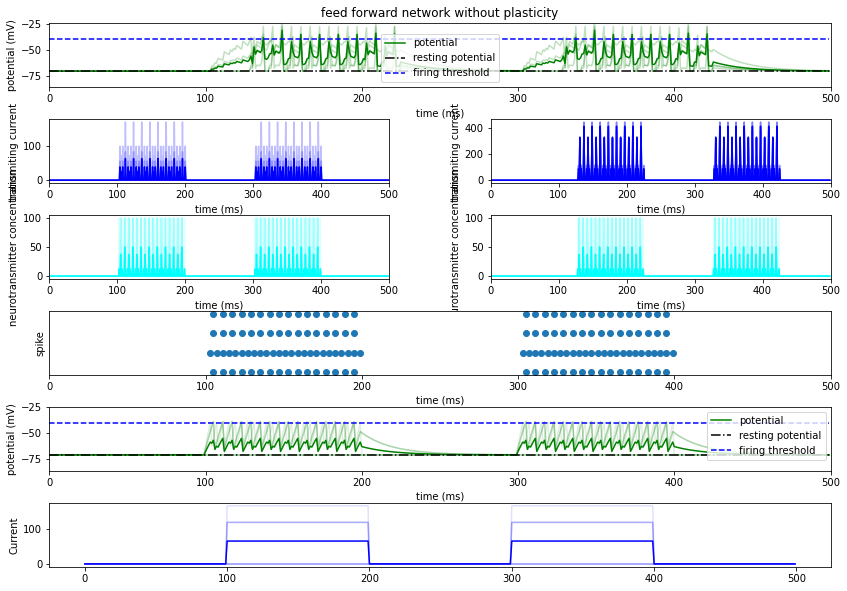

In [3]:
n1 = LIF(name='A', shape=(4,), batch=2, dt=1., analyzable=True)
a1 = Axon(response_function=ScalingResponseFunction(scale=100.), analyzable=True)
a2 = Axon(response_function=ScalingResponseFunction(scale=100.), delay=25., terminal=(2,), analyzable=True)
s1 = DisconnectorSynapticCover(FullyConnectedSynapse)(connectivity_pattern=RandomFixedPresynapticPartnersConnectivity(rate=.5))
s2 = FullyConnectedSynapse()
d1 = LinearDendrite(plasticity_model=ConvergentSynapticPlasticity(tau=100), analyzable=True)
d2 = LinearDendrite(analyzable=True)
n2 = LIF(name='B', shape=(2,), batch=2, dt=1., analyzable=True)

n1.use(a1).use(a2)
n2.use(d1).use(d2)
s1.connect(a1).connect(d1)
s2.connect(a2).connect(d2)

net = Network(dt=1., batch=2)
net.insert(n1).insert(n2).insert(s1).insert(s2)
net.plasticity = False
net.reset()

sim = Simulator(net.progress)
sim.simulate(inputs={'external_inputs': {'A': {'direct_input': I}}}, times=500)

plt.figure(figsize=(14,10))
md = MatplotlibDashboard([
        ['U2','U2'],
        ['D1','D2'],
        ['A1','A2'],
        ['S1','S1'],
        ['U1','U1'],
        ['I','I'],
    ], hspace=.5, wspace=.3)

md['I'].plot(I.reshape(I.shape[0], -1), alpha=1/I[0].numel(), color='blue')
md['I'].plot(I.reshape(I.shape[0], -1).mean(axis=[1]), color='blue')
md['I'].set_ylabel('Current')
n1.plot_potential(md['U1'])
n1.plot_spikes(md['S1'])
a1.plot_neurotransmitter(md['A1'])
a2.plot_neurotransmitter(md['A2'])
d1.plot_transmiting_current(md['D1'])
d2.plot_transmiting_current(md['D2'])
n2.plot_potential(md['U2'])
md['U2'].set_title('feed forward network without plasticity')
plt.show()

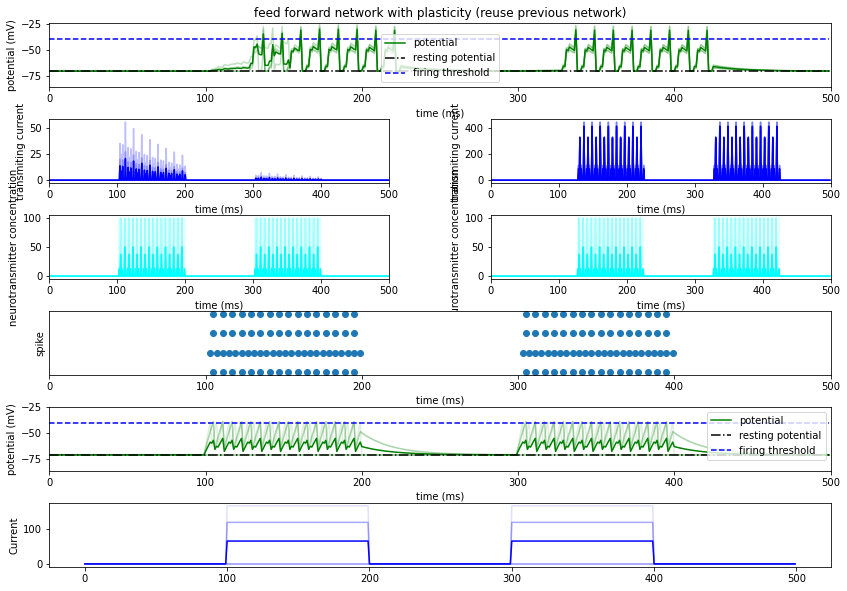

In [4]:
net.plasticity = True
net.reset()
sim.simulate(inputs={'external_inputs': {'A': {'direct_input': I}}}, times=500)

plt.figure(figsize=(14,10))
md = MatplotlibDashboard([
        ['U2','U2'],
        ['D1','D2'],
        ['A1','A2'],
        ['S1','S1'],
        ['U1','U1'],
        ['I','I'],
    ], hspace=.5, wspace=.3)

md['I'].plot(I.reshape(I.shape[0], -1), alpha=1/I[0].numel(), color='blue')
md['I'].plot(I.reshape(I.shape[0], -1).mean(axis=[1]), color='blue')
md['I'].set_ylabel('Current')
n1.plot_potential(md['U1'])
n1.plot_spikes(md['S1'])
a1.plot_neurotransmitter(md['A1'])
a2.plot_neurotransmitter(md['A2'])
d1.plot_transmiting_current(md['D1'])
d2.plot_transmiting_current(md['D2'])
n2.plot_potential(md['U2'])
md['U2'].set_title('feed forward network with plasticity (reuse previous network)')
plt.show()

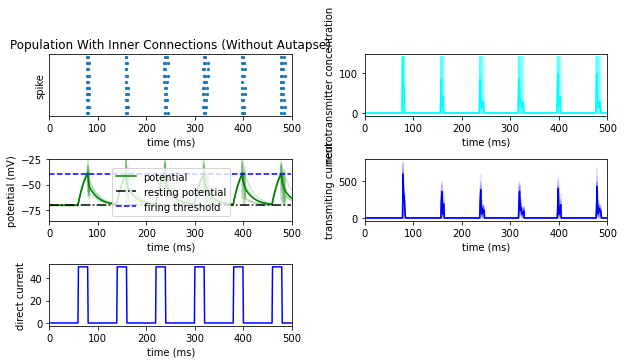

In [5]:
population = 10
n = LIF(name='A', shape=(population,), batch=1, dt=1., analyzable=True)
a = Axon(response_function=ScalingResponseFunction(scale=140.), analyzable=True)
s = DisconnectorSynapticCover(FullyConnectedSynapse)(connectivity_pattern=InvertConnectivity(AutapseConnectivity)())
d = LinearDendrite(analyzable=True)

n.use(a).use(d)
s.connect(a).connect(d)

net = Network(dt=1., batch=2)
net.insert(n).insert(s)
net.reset()

I = FunctionGenerator.generate(500, shape=(1, population,),
                               baseline={20*i: 50.*(i%4==3) for i in range(25)})
sim = Simulator(net.progress)
sim.simulate(inputs={'external_inputs': {'A': {'direct_input': I}}}, times=500)

plt.figure(figsize=(10,5))
md = MatplotlibDashboard([
        ['S','A'],
        ['U','D'],
        ['I',None],
    ], hspace=.7, wspace=.3)

n.plot_potential(md['U'])
n.plot_spikes(md['S'], s=5)
a.plot_neurotransmitter(md['A'])
d.plot_transmiting_current(md['D'])
md['I'].plot(I.reshape(I.shape[0], -1).mean(axis=[1]), color='blue')
md['I'].set_xlim((0,500))
md['I'].set_xlabel('time (ms)')
md['I'].set_ylabel('direct current')
md['S'].set_title('Population With Inner Connections (Without Autapse)')
plt.show()

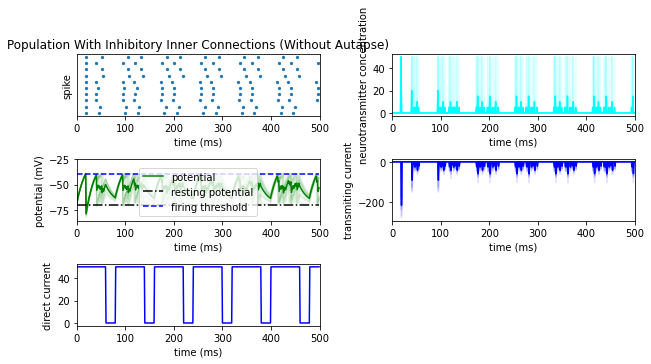

In [6]:
population = 10
n = LIF(name='A', shape=(population,), batch=1, dt=1., analyzable=True)
a = Axon(response_function=ScalingResponseFunction(scale=50.), is_excitatory=False, analyzable=True)
s = DisconnectorSynapticCover(FullyConnectedSynapse)(connectivity_pattern=InvertConnectivity(AutapseConnectivity)())
d = LinearDendrite(analyzable=True)

n.use(a).use(d)
s.connect(a).connect(d)

net = Network(dt=1., batch=2)
net.insert(n).insert(s)
net.reset()

I = FunctionGenerator.generate(500, shape=(1, population,),
                               baseline={20*i: 50.*(i%4!=3) for i in range(25)})
sim = Simulator(net.progress)
sim.simulate(inputs={'external_inputs': {'A': {'direct_input': I}}}, times=500)

plt.figure(figsize=(10,5))
md = MatplotlibDashboard([
        ['S','A'],
        ['U','D'],
        ['I',None],
    ], hspace=.7, wspace=.3)

n.plot_potential(md['U'])
n.plot_spikes(md['S'], s=5)
a.plot_neurotransmitter(md['A'])
d.plot_transmiting_current(md['D'])
md['I'].plot(I.reshape(I.shape[0], -1).mean(axis=[1]), color='blue')
md['I'].set_xlim((0,500))
md['I'].set_xlabel('time (ms)')
md['I'].set_ylabel('direct current')
md['S'].set_title('Population With Inhibitory Inner Connections (Without Autapse)')
plt.show()